# Large Deformation Diffeomorphic Image Registration : Laplacian Pyramid Networks (LapIRN)

### Introduction: 

The project and the article's main aim is to perform deformable registration. What differs from other existing DL based methods is that the latter are usually limited in terms of the properties that the transformation preserves (Bijective mapping for example ...). 
The deep Laplacian Pyramid Image Registration Network is based on a coarse-to-fine strategy that allows a better registration. 

**Where are these methods used?**

- Diagnostic tasks. 
- Radiotherapy
- image guided surgery ...

**Why is this method better than other DLIR methods?**

- At the finest Resolution, the gradient of the similarity metric is rough. 
- It is hard to solve the optimization problem without the initialization at the fine resolution. 

### Description of the method:

*Notations*

- F the fixed 3D scanned image. 
- M the moving scan image. 

The aim is to have $\phi$ as an output for the model. 
$$
f_{\theta}(F,M) = \phi^{(1)}
$$
with $\theta$ the network's parameters. 

**Architecture of the network**

The architecture of the model is as shown on the picture below: (We can give a summary if necessary)

**CNN used for this method : architecture and parameters**

The following architecture is the same for all the pyramid levels. Its main components are : 
- Feature encoder.
- R residual blocks. 
- Feature decoder.

We train our model in a coarse-to-fine training scheme. That means that we first train it from the coarsest level alone then we add the network from the next level to learn at a finer resolution. 

**Similarity metric used for the problem**


To address the problem that we have, the method suggests we use a similarity pyramid framework. It can be formulated using the local normalized cross coreelation. 
$$
S^K(F,M) = \sum_{i \in {1,..,K}} \frac{-1}{2^{(K-i)}} NCC_{w}(F_i,M_i)
$$
The window size of the NCC is $w^3$. 
We can notice that the lower the resolution, the lower the weight we assign to the similarity value. The purpose of this measure is to avoid the possibility of dominant low resolutions. 

Thus, the optimization problem we have to solve is the following: 
$$
L_p(F, M(\phi), v) = S^p(F,M(\phi)) + \frac{\lambda}{2^(L-p)} \left\|\nabla v\right\|_{2}^2
$$
- p : the current pyramid level. 
- v : smoothness regularization field. 
- $\lambda$ : the regularization parameter. 

**Diffeomorphy of $\phi$**

The deformation field is usually represented in the following way $\phi(x) = x + u(x)$ with $u(x)$ the displacement vector. It is very commun but it doesn't meet our requirements for our application on brain images. In fact, the clinical usage of the methods requires diffeomorphic properties. That's the deformation model will be parametrized differently using the velocity field $\frac{d\phi_t}{dt} = v(\phi_t)$ ($\phi_0 = Id$). For the rest of this report, $LapIRN$ is our method that uses velocity field and $LapIRN_{disp}$ the variant that uses displacement fields instead

### Evaluation of the method: 

We dont evaluate our method only based on the dice score, but on a sequence of measurements that allow us to test its performance regarding all aspects. For example, we have : 
- $\left|J_{\phi}\right|_{\le 0}$ : The percentage of voxels with non-positive jacobian determinant.
- $std(\left|J_{\phi}\right|)$ : the standard deviation of the jacobian determinant on the deformation fields, it indicates the smoothness of the deformation fields (the lower it is , the better).
- $TC$ : the volume change between the segmentation maps before and after the transformation, the objective is to have it as close to 1 as possible.  
- $Time$ : The average runnung registration time. 


### Comparison of the results:

#### LapIRN:

In the code below, we will try to compare our method (LapIRN) and the method of the previous article (voxelmorph), and that in terms of : 
- Dice score 
- MSE loss

First, let's retrieve the data from the git.

In [ ]:
!git clone https://github.com/cwmok/LapIRN.git

Cloning into 'LapIRN'...
remote: Enumerating objects: 45, done.
remote: Total 45 (delta 0), reused 0 (delta 0), pack-reused 45
Unpacking objects: 100% (45/45), done.


In [ ]:
!python LapIRN/Code/Test_LapIRN_disp.py

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Finished


We should also define a function that computes the dice score given two segentation images. 

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np


def dice_score(seg1, seg2):
    dice=0.0
    for i in range(len(seg1)):
        dice += 2*np.sum(seg1*seg2 == 1)/(np.sum(seg1 == 1) + np.sum(seg2 == 1))

    return dice/len(seg1)

In [ ]:
source=nib.load('LapIRN/Data/image_B.nii').get_fdata()
target=nib.load('LapIRN/Data/image_A.nii').get_fdata()
moving = nib.load('Result/warpped_moving.nii.gz').get_fdata()
flow = nib.load('Result/warpped_flow.nii.gz').get_fdata()

The sourse, target, moving images and the flow have the following shapes : 

In [ ]:
source.shape,target.shape,moving.shape,flow.shape

((160, 192, 144), (160, 192, 144), (160, 192, 144), (160, 192, 144, 3))

The following is the MSE loss resulting from the LapIRN registration:

In [ ]:
vxm.losses.MSE().loss(target,moving)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0008509872094072762>

The following is the Dice Score obtained from a LapIRN registration of two brain images:

In [ ]:
dice_score(target>0.1,moving>0.1)

0.9834422745149738

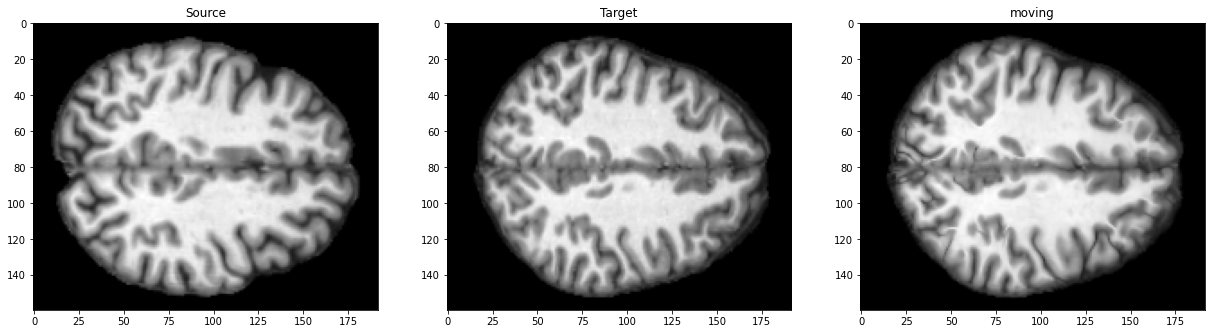

In [ ]:
l=100
x,y = np.meshgrid(np.linspace(0,192,192),np.linspace(0,160,160))
u,v=flow[...,l,0],flow[...,l,1]
#u,v = flow[0][0].detach().numpy(),flow[0][1].detach().numpy()
c=u*u+v*v

plt.figure(figsize=(21,7))
plt.subplot(131)
plt.title("Source")
plt.imshow(source[...,l],cmap='gray')
#plt.colorbar()
#plt.quiver(x,y,-u,-v,c,scale_units="xy",scale=1)


plt.subplot(132)
plt.title("Target")
plt.imshow(target[...,l],cmap='gray')
##plt.quiver(x,y,u,v,c,scale_units="xy",scale=1)

plt.subplot(133)
plt.title("moving")
plt.imshow(moving[...,l],cmap='gray')
#plt.quiver(x,y,u,v,c,scale_units="xy",scale=1).detach().numpy()


#### Voxelmorph

In [ ]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph > /dev/null 2>&1  

In [ ]:
import os, sys
import numpy as np
import voxelmorph as vxm
import neurite as ne
import tensorflow as tf

In [ ]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2021-06-20 18:28:03--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16643404 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  15.1MB/s    in 1.1s    

2021-06-20 18:28:05 (15.1 MB/s) - ‘data.tar.gz’ saved [16643404/16643404]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
subj1.npz
subj2.npz
tutorial_data.npz


In [ ]:
# our data will be of shape 160 x 192 x 224
vol_shape = (160, 192, 144)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

In [ ]:
val_volume_1 = np.load('subj1.npz')['vol']
val_volume_2 = np.load('subj2.npz')['vol']

# val_volume_1 = nib.load('LapIRN/Data/image_B.nii').get_fdata()
# val_volume_2 = nib.load('LapIRN/Data/image_A.nii').get_fdata()

val_input = [
    val_volume_1[np.newaxis, ..., np.newaxis],
    val_volume_2[np.newaxis, ..., np.newaxis]
]
vxm_model.load_weights('brain_3d.h5')

In [ ]:
val_volume_1.shape,val_volume_2.shape

((160, 192, 224), (160, 192, 224))

In [ ]:
%time
val_pred = vxm_model.predict(val_input)

In [ ]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

target


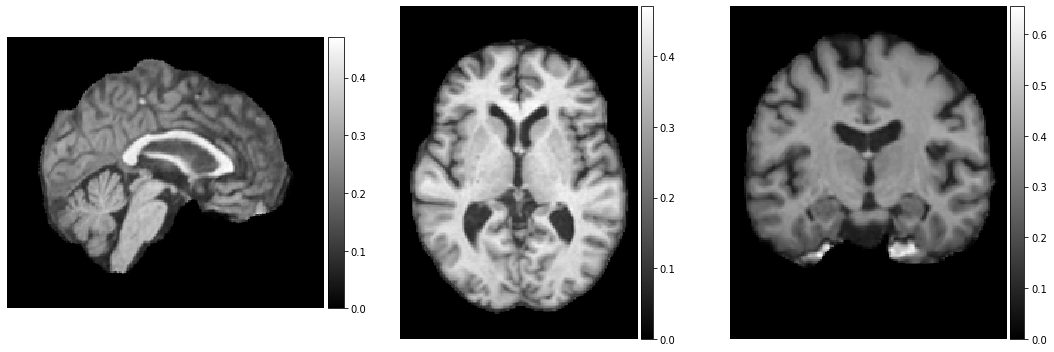

In [ ]:
print("target")
mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)
ne.plot.slices(mid_slices_fixed, cmaps=['gray'], do_colorbars=True, grid=[1,3]);

moved


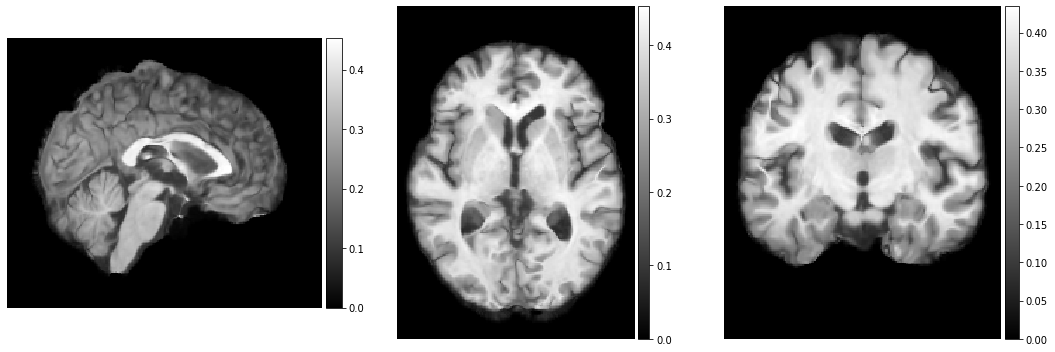

In [ ]:
print("moved")
mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[1,3]);

#Now with image of the code

In [ ]:
val_volume_1 = nib.load('LapIRN/Data/image_B.nii').get_fdata()
val_volume_2 = nib.load('LapIRN/Data/image_A.nii').get_fdata()

In [ ]:
val_volume_1.shape,val_volume_2.shape

((160, 192, 144), (160, 192, 144))

In [ ]:
val_input = [
    val_volume_1[np.newaxis, ..., np.newaxis],
    val_volume_2[np.newaxis, ..., np.newaxis]
]

In [ ]:
%time
val_pred = vxm_model.predict(val_input)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.58 µs


In [ ]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

target


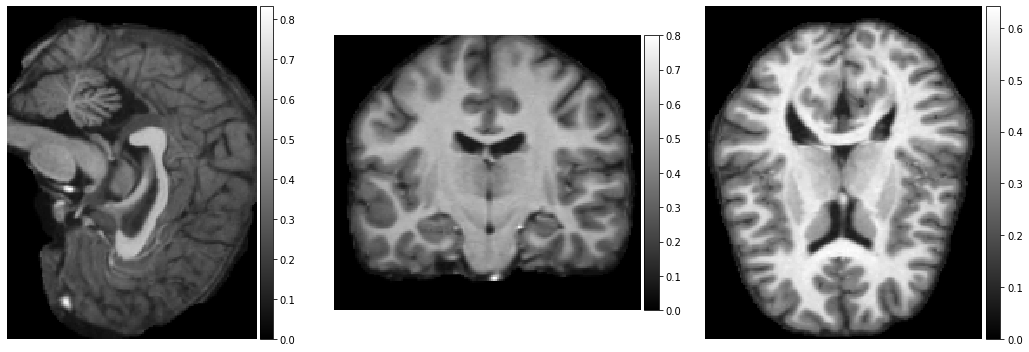

In [ ]:
print("target")
mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)
ne.plot.slices(mid_slices_fixed, cmaps=['gray'], do_colorbars=True, grid=[1,3]);

moved


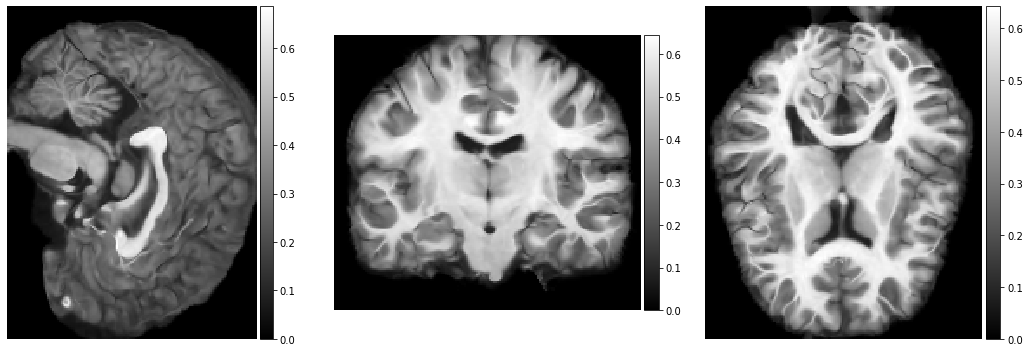

In [ ]:
print("moved")
mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[1,3]);

In [ ]:
moving.shape

(160, 192, 144)

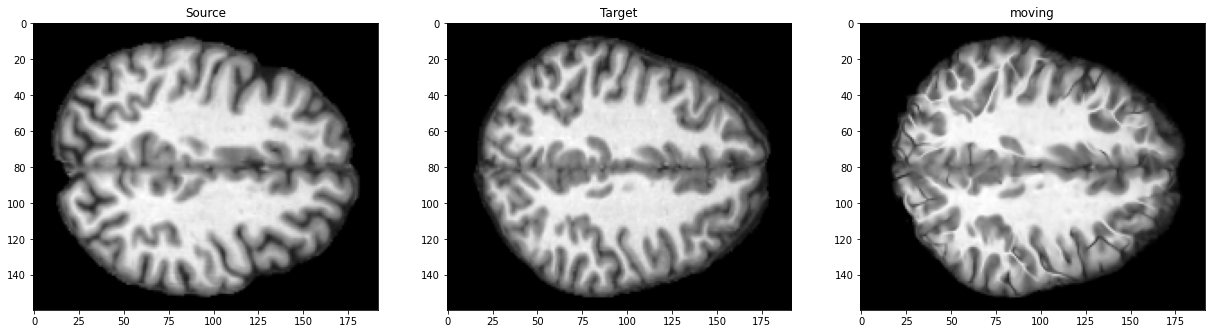

In [ ]:
source= val_input[0]
target=val_input[1]
moving = moved_pred
flow = pred_warp

l=100
x,y = np.meshgrid(np.linspace(0,192,192),np.linspace(0,160,160))
u,v=flow[...,l,0],flow[...,l,1]
#u,v = flow[0][0].detach().numpy(),flow[0][1].detach().numpy()
c=u*u+v*v

plt.figure(figsize=(21,7))
plt.subplot(131)
plt.title("Source")
plt.imshow(source[0,...,l,0],cmap='gray')
#plt.colorbar()
#plt.quiver(x,y,-u,-v,c,scale_units="xy",scale=1)


plt.subplot(132)
plt.title("Target")
plt.imshow(target[0,...,l,0],cmap='gray')
##plt.quiver(x,y,u,v,c,scale_units="xy",scale=1)

plt.subplot(133)
plt.title("moving")
plt.imshow(moving[...,l],cmap='gray')
#plt.quiver(x,y,u,v,c,scale_units="xy",scale=1).detach().numpy()

In [ ]:
target.shape,moving.shape

((1, 160, 192, 144, 1), (160, 192, 144))

In [ ]:
vxm.losses.MSE().loss(target[0,...,0],moving)

<tf.Tensor: shape=(), dtype=float64, numpy=0.001508689173120018>

In [ ]:
dice_score(target[0,...,0]>0.1,moving>0.1)

0.9778177364408883

We can notice from the results above that, in terms of the dice score and MSE loss, LapIRN outscores voxelmorph, with a dice score of 0.98 and a loss of 0.00085.

In fact, the dice score and the loss only evaluates the registration accuracy. the methods can be evaluated using other metrics, such as the jacobian determinant and its standard deviation. According to the article, the latter is lower for LapIRN than it is for voxelmorph. This aspect actually shows that the deformation field is smoother with the LapIRN method. The LapIrn method also outperforms voxelmorph in terms of the running time. 

The results shown in the article concern two datasets, one is larger than the other. Once again, LapIRN takes the lead by outperforming on datasets with a small training set. 


### Conclusion


Thanks to the LapIRN method we could find a compromise between the registration accuracy, the diffeomorphic properties of the solution and a good executional time.